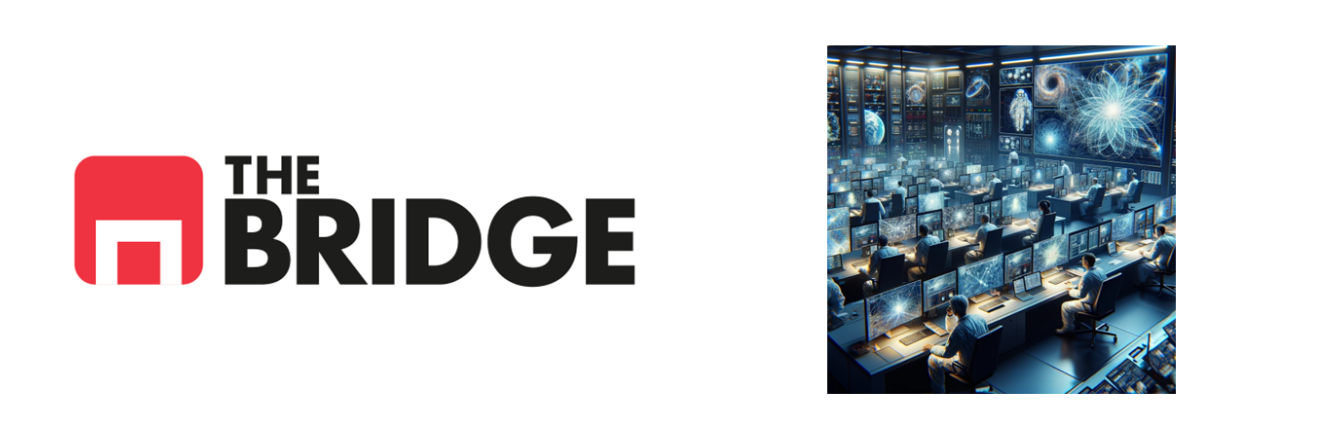

*RECUERDA QUE ESTE NOTEBOOK ES PARA QUE LO EJECUTES EN TU ORDENADOR, NO EN LA PLATAFORMA*


## Transfer Learning y Fine Tuning

Como hemos visto en la teoria, una de las capacidades más potentes de los modelos DL es que podemos apoyarnos en modelos preentrenados (o preconstruidos si solo queremos su topología). En las siguientes sesiones vamos a emplear dos modelos de este tipo de redes convolucionales especializadas en la clasifiación de imagénes para mostrar los conceptos de transfer y fine tuning.

### Principales arquitecturas convolucionales

Al finalizar la unidad anterior vimos cuatro arquitecturas de referencia de las cuales hoy en día hay buenas evoluciones:

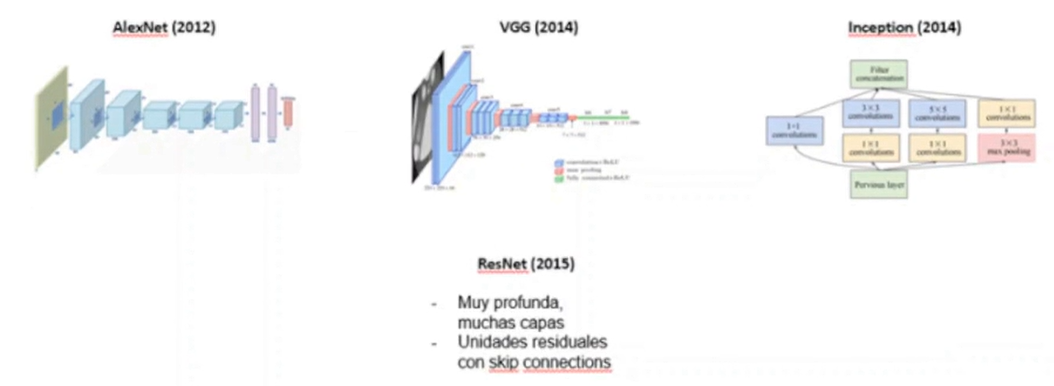

Y hoy en día son arquitecturas basadas en las anteriores la más utilizadas en la comunidad:
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

Para más detalle sobre el funcionamiento de cada red, consultar el [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch14.html#cnn_chapter).

NOTA: Un detalle es que estas redes las puedes bajar sólo su topología o con los pesos preentrenados.


***

## Zero-Shot Learning

La primera arquitectura que vamos a ver corresponde a la **ResNet50V2**. Además lo primero que vamos a intentar con ella es un zero-shot learning que básicamente consiste en bajar la red preentrenada coger nuestros datos, adaptarlos a las dimensiones de entrada de la ResNet y hacer predicciones directamente.

<img src="./img/ResNet50.png" alt="drawing" width="600"/>

Lo primero es hacer nuestros "imports", fijate que además de los habituales importamos skimage y cv2 para poder ver y tratar las imágenes:

In [1]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras._tf_keras import keras
from keras._tf_keras.keras import datasets, layers, models
from keras._tf_keras.keras.preprocessing import image
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from utils.functions import remove_non_zip_folders, unzip_files

# Pylance not working
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.preprocessing import image

Y ahora nos descargamos "el modelo" (realmente es un clase que cargará el modelo al inicializarse):

In [2]:
from keras._tf_keras.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

# Pylance not working
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [3]:

'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''
# include_top=True --> Como vamos a emplearla directamente, incluimos también la parte de 
# capas densas que hacen la predicción en este caso clasificación de imagenes.
# weights="imagenet" --> Se carga con los pesos entrenados para el dataset de imagenet
base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True,   
                        weights="imagenet", 
                        classifier_activation="softmax")

In [4]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

Cargamos algunas imagenes desde local, para ver qué tal funciona la red ResNet50V2 ya entrenada.

In [5]:
#!rm -r validation_folder

In [6]:
# !mkdir data

In [7]:
# import zipfile

# path_to_zip_file = "./img"
# directory_to_extract_to = "./data/"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [8]:
# Leer ficheros .jpg

tipos = []

def read_data(path):
    X = []

    for file in [file for file in os.listdir(path) if file.endswith(".jpg") or file.endswith(".jpeg")]:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (224, 224))
        print(path + '/' + file)
        tipos.append(file)

        X.append(smallimage)

    return np.array(X)


x_figs = read_data('./img')

# Procesar las imagenes tal y como entran en el modelo
x_test = preprocess_input(x_figs)
print(x_test.shape)

./img/bear-1.jpg
./img/bond.jpg
./img/cat.8016.jpg
./img/cat.8037.jpg
./img/dog.11856.jpg
./img/dog.11857.jpg
./img/horse.jpg
./img/karate.jpg
./img/novia.jpeg
./img/pizza.jpg
(10, 224, 224, 3)


`NOTA`: Solo hemos leido los .jpg.

In [9]:
def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({true_label})")


def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

  #thisplot[predicted_label].set_color('red')
  #thisplot[true_label].set_color('blue')

Ahora predecimos sobre las imagenes nuestras, como puedes ver, sin tocar nada más en el modelo

In [10]:
num_rows = len(x_test)
num_cols = 1
num_images = num_rows * num_cols

#plt.figure(figsize=(40, 40))

preds = base_model.predict(x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Y mostramos cada imagen y el nivel de confianza en las etiquetas top que puede dar ResNet

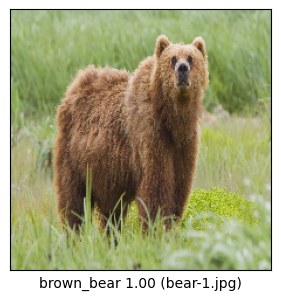

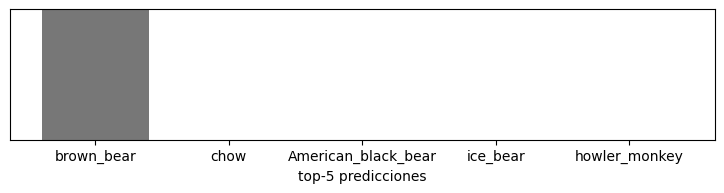

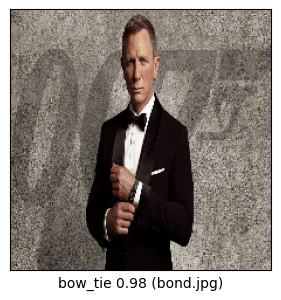

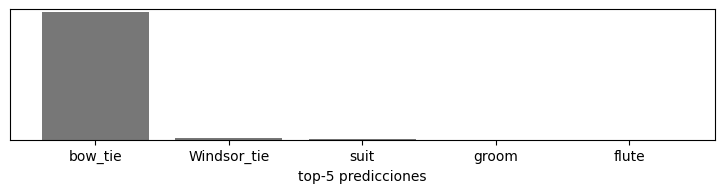

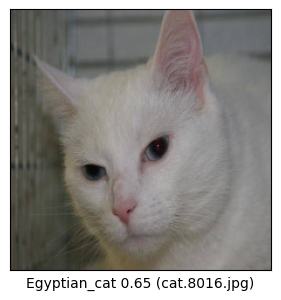

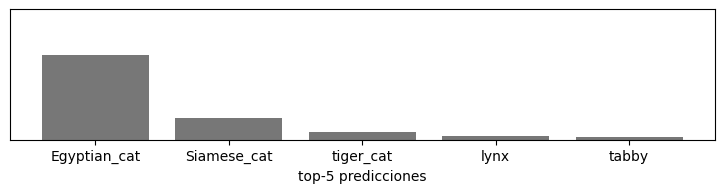

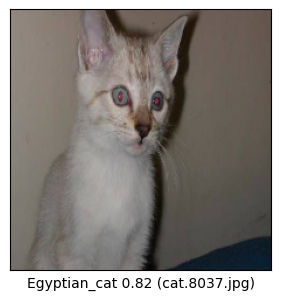

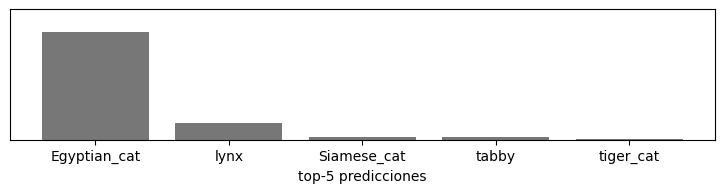

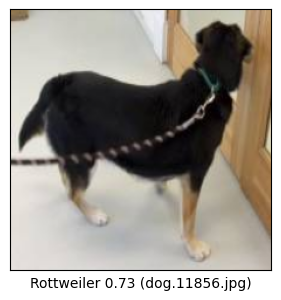

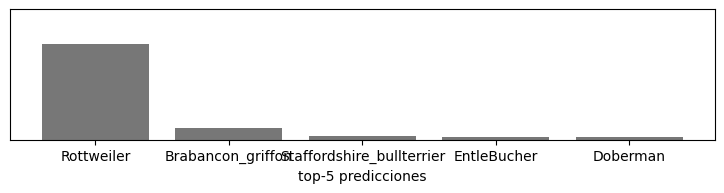

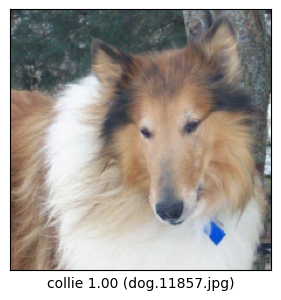

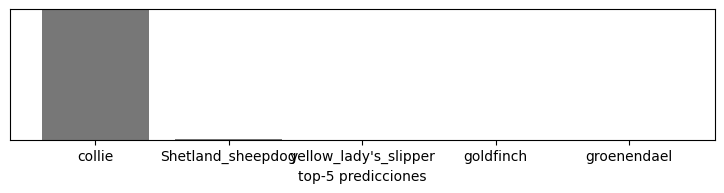

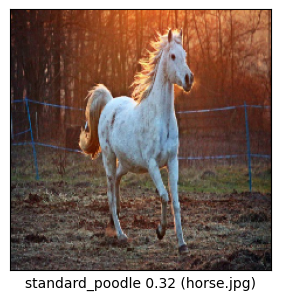

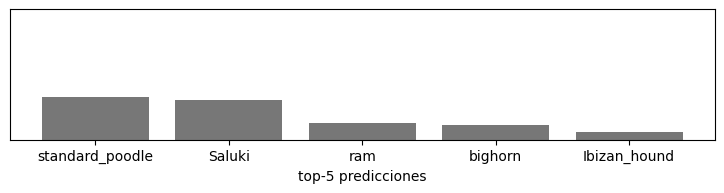

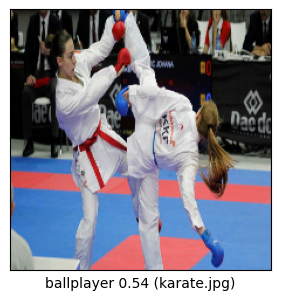

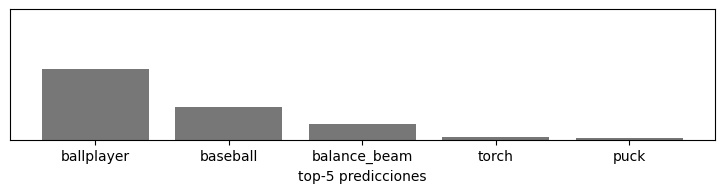

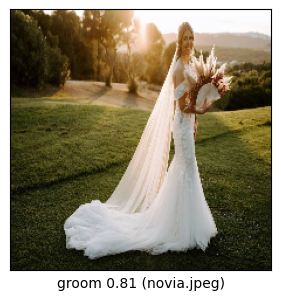

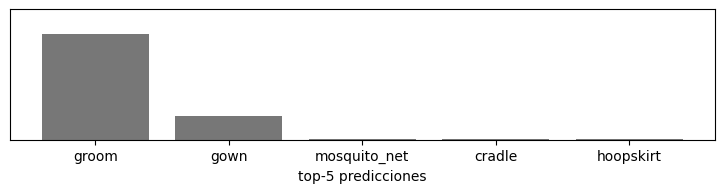

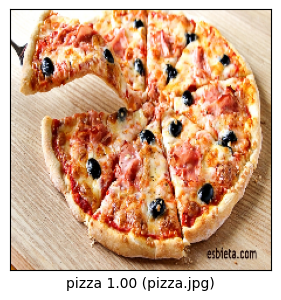

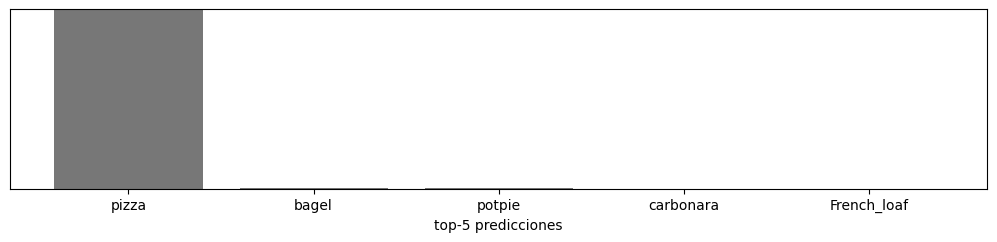

In [11]:
# decode the results into a list of tuples (class, description, probability)
decodes = decode_predictions(preds, top=5)

for i,j in enumerate(decodes):
    prediction_proba = []
    predicted_classes = []
    for decode in j:
        prediction_proba.append(decode[2])
        predicted_classes.append(decode[1])
    plt.figure(figsize=(40, 40))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predicted_classes[0],prediction_proba[0],tipos[i],x_figs)
    plt.figure(figsize=(20, 20))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(prediction_proba, predicted_classes)
plt.tight_layout()
plt.show()

En algunos casos los resultados son muy buenos en otros son "raros", por ejemplo la "Pajarita" de James Bond. No siempre podremos hacer un zero-shot de hecho eso está siendo ahora con los LLMs con los que realmente está funcionando.

***

## Transfer Learning

Si recuerdas en el transfer a diferencia del shot, vamos a mantener el modelo quitándole su "cabeza" densa y colocando una que entrenaremos con nuestros datos. Pues vamos a ello.

NOTA: No todos los modelos tienen la misma forma de hacer el transfer o el fine tuning que vamos a enseñar aquí, la filosofía es la misma pero los pasos pueden diferir por implementación, datos, etc. Cuando quieras recurrir a este sistema deberás leer las instrucciones que acompañen al modelo escogido en el repositorio del que te lo vayas a descargar.

Para este caso vamos a emplear el modelo basado en la arquitectura **VGG**:

<img src="./img/vgg16.png" alt="drawing" width="150"/>

Y los datos de imagenes de perros y gatos de la práctica obligatoria pasada, así que cambia el path de la celda siguiente para que apunte al lugar donde tengas las imagenes de train de esa práctica

In [12]:
# import zipfile
# path_to_zip_file = "./data.zip"
# directory_to_extract_to = "./data/"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [13]:
# Rutas a los archivos .zip
zip_files = [
    './data/github_train_0.zip',
    './data/github_train_1.zip',
    './data/github_train_2.zip',
    './data/github_train_3.zip',
    './data/github_test.zip'
]

# Extraer los ficheros contenidos en la carpeta ./data
for zip_file in zip_files:
    unzip_files(zip_file, './data/')

Extracted ./data/github_train_0.zip to ./data/
Extracted ./data/github_train_1.zip to ./data/
Extracted ./data/github_train_2.zip to ./data/
Extracted ./data/github_train_3.zip to ./data/
Extracted ./data/github_test.zip to ./data/


In [14]:
DATA_PATH = './data/'
IM_SIZE=64

filenames = []
df_total = pd.DataFrame()

for n in range(4):
    
    TRAIN_PATH = f'github_train_{n}/'
    filenames = os.listdir(DATA_PATH + TRAIN_PATH)
    categories = []

    for filename in filenames:
        category = filename.split('.')[0]
        categories.append(category)

    df = pd.DataFrame({
        'filenames': filenames,
        'category': categories
    })

    df['filenames'] = df['filenames'].apply(lambda x: TRAIN_PATH + x)
    df_total = pd.concat([df_total,df])


df_train, df_validate = train_test_split(df_total,
                                         test_size=0.20,
                                         random_state=42,
                                         stratify=df_total['category'])

df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

df_total

,filenames,category
0,github_train_0/cat.1000.jpg,cat
1,github_train_0/cat.10010.jpg,cat
2,github_train_0/cat.10012.jpg,cat
3,github_train_0/cat.10013.jpg,cat
4,github_train_0/cat.10017.jpg,cat
...,...,...
995,github_train_3/dog.9985.jpg,dog
996,github_train_3/dog.9992.jpg,dog
997,github_train_3/dog.9993.jpg,dog
998,github_train_3/dog.9998.jpg,dog


In [15]:
df_validate

,filenames,category
0,github_train_3/dog.11862.jpg,dog
1,github_train_2/dog.11902.jpg,dog
2,github_train_1/cat.10032.jpg,cat
3,github_train_3/dog.10957.jpg,dog
4,github_train_3/dog.10762.jpg,dog
...,...,...
795,github_train_3/dog.12045.jpg,dog
796,github_train_0/cat.10096.jpg,cat
797,github_train_1/cat.3819.jpg,cat
798,github_train_1/cat.1285.jpg,cat


`No hemos cargado los ficheros`, solo creado ese dataframe con info de los nombres y categorías.

In [16]:
# ############## WARNING ############## WARNING ###############
# Estas líneas están deprecadas porque los datos ahora están almecenados
# en subcarpetas "github_train_n", pero puede ser útil en el futuro.
# ############## WARNING ############## WARNING ###############

# ########## copiar los ficheros en una nueva ruta ############
# os.mkdir('./data/github_train')
# os.mkdir('./data/github_validation')

# for registro in train_df.filenames:
#   shutil.copy(registro, './data/github_train')

# for registro in validate_df.filenames:
#   shutil.copy(registro, './data/github_validation')

# ################# OTRA FORMA DE HACER SPLIT #################

# cada directorio tiene 1000 fotos
# df_gatos_perros_train = pd.concat([df_total[:1500], df_total[2000:3500]]) # como hay 2k gatos y 2k perros, cojo 1500 gatos + 1500 perros para train
# df_gatos_perros_validacion = pd.concat([df_total[1500:2000], df_total[3500:]]) # cojo 500 gatos y 500 perros para validacion

# ################ OTRA FORMA DE HACER SHUFFLE ################
# n = 500
# while n >= 0:
#   df_gatos_perros_train = df_gatos_perros_train.sample(frac=1)
#   df_gatos_perros_validacion = df_gatos_perros_validacion.sample(frac=1)
#   n -= 1

#### ImageDataGenerator

Para poder mejorar la generalización del modelo vamos a emplear un `aumentado de imágenes`:

In [17]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40, # Rotacion en grados
                                   width_shift_range=0.2, # Desplazamiento a lo ancho
                                   height_shift_range=0.2,
                                   shear_range=0.2, # Intensidad del angulo de rotacion
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

Una de las ventajas de los generadores de imágenes sintéticas de tensorflow es que pueden leer imágenes a partir de fichero en vez de tener que pasarles directamente los arrays de cada una de ellas.

Lo que vamos a construir es un `generador en Python`. Hasta que no lo llamo no me va dando datos (lo puedo meter por ejemplo en un iterable).

In [18]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory='./data/',        # Donde buscar todo esto
                                                    x_col='filenames',          # Nombres de archivos
                                                    y_col='category',           # Target
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_validate,
                                                              directory='./data/',
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(IM_SIZE, IM_SIZE))

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


Después de aplicar este proceso de aumento de datos (data augmentation), sigues teniendo 3000 datos de entrenamiento y 1000 datos de validación, pero los datos de entrenamiento se transforman aleatoriamente cada vez que se utilizan. Es decir, no se crean nuevos datos ni se guardan copias adicionales en memoria, pero cada vez que el modelo solicita un lote de imágenes, las imágenes se modifican sobre la marcha según las transformaciones especificadas (rotación, zoom, desplazamiento, etc.).

En resumen:

- No aumenta el número total de datos en el conjunto de entrenamiento ni de validación.
- El conjunto de entrenamiento parece "más grande" porque, cada vez que el modelo ve una imagen, podría estar ligeramente diferente debido a las transformaciones.
- El conjunto de validación no se altera con aumentos de datos, por lo que siempre será el mismo (en tu caso, con 1000 datos).

Cargamos el modelo como hicimos antes con ResNet

In [19]:
from keras._tf_keras.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import VGG16

# La instanciamos sin pedir las "cabezas" (las tres capas densas). Pero el resto va a venir con sus pesos
# input_shape=(IM_SIZE, IM_SIZE, 3) --> Shape of our images
# include_top=False --> Leave out the last fully connected layer
base_model = VGG16(input_shape=(IM_SIZE, IM_SIZE, 3),
                   include_top=False,                      
                   weights='imagenet'
                   )


Fijate en el argumento include_top, está puesto ahora a False para poder quitar la cabecera densa de la VGG. Ahora tenemos que añadirle la red densa que queramos entrenar nosotros, en este caso va a ser muy sencilla. Y para poder añadirla sobre el resto de la arquitectura de la VGG, recurrimos a la interfaz funcional que vimos el sprint anterior

Observa también que vamos a "congelar" las capas de la VGG, es decir, no vamos a permitir que se entrenen haciendo lo siguiente:

In [20]:
# Vamos a congelar las capas para que los pesos no cambién
for layer in base_model.layers:
    layer.trainable=False


Y ahora ya sí nuestro modelo "tuneado":

In [21]:
##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(base_model.input, x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,289 (60.14 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Y ya ahora solo tenemos que entrenar:

In [22]:
# steps_per_epoch = Cantidad de batches en los que divide el epoch
vgghist = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,   
                    epochs=10)

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - acc: 0.6154 - loss: 0.7279 - val_acc: 0.7237 - val_loss: 0.5298
Epoch 2/10
 60/100 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - acc: 0.6868 - loss: 0.5930

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - acc: 0.6831 - loss: 0.5974 - val_acc: 0.7325 - val_loss: 0.5494
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - acc: 0.7019 - loss: 0.5542 - val_acc: 0.7312 - val_loss: 0.5128
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - acc: 0.6950 - loss: 0.5633 - val_acc: 0.7375 - val_loss: 0.5402
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - acc: 0.7334 - loss: 0.5358 - val_acc: 0.7487 - val_loss: 0.5379
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - acc: 0.7305 - loss: 0.5265 - val_acc: 0.7387 - val_loss: 0.5078
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - acc: 0.7238 - loss: 0.5633 - val_acc: 0.7412 - val_loss: 0.5228
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - acc: 0.7353 - loss: 0.5163 - val_acc: 0.7437 - val_loss: 0.5334
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - acc: 0.7509 - loss: 0.5293 - val_acc: 0.7475 - val_loss: 0.5088
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14

Lo que hemos hecho ha sido entrenar solo la capa densa y la capa de salida.

Y tenemos nuestro modelo sobre la VGG, vamos a evaluarlo (ahora sí que vamos a convertir las imagenes a arrays de numpy) directamente sobre el test:

In [23]:
# train_folder hardcodeado por ir más rápido en el ejercicio

os.mkdir('./data/github_train')

for registro in df_train['filenames']:
  shutil.copy(DATA_PATH + registro, DATA_PATH + 'github_train')


In [24]:

TEST_PATH = "./data/github_test/"

def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (im_size,im_size))

        X.append(smallimage/255.)

        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)

# train_folder hardcodeado por ir más rápido en el ejercicio
X_train, y_train = read_data(DATA_PATH + 'github_train', IM_SIZE) 
X_test, y_test = read_data(TEST_PATH, IM_SIZE)

`CUIDADO!` porque no está barajado, si no que lo ha vuelto a coger alfabéticamente y primero están todos los gatos y después todos los perros.

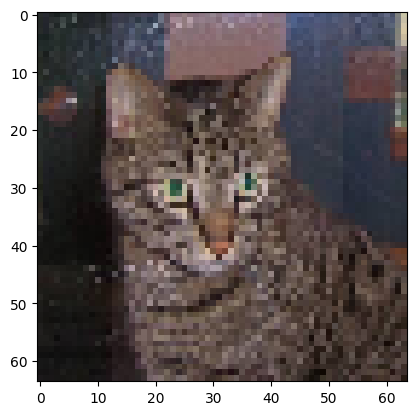

In [25]:
plt.imshow(X_train[0])
plt.show()

In [26]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - acc: 0.8024 - loss: 0.4276
test loss, test acc: [0.4432268738746643, 0.7940000295639038]


Bueno, no esta mal, pero igual podríamos hacer más... Veamos una segunda posibilidad dentro del transfer learning que ya roza bastante o se solapa con el fine-tuning

***

## Transfer Learning con entrenamiento de capas superiores

Veamos las capas de nuestro modelo (version del VGG):

In [27]:
for indice, layer in enumerate(model.layers):
    print("Capa %d: %s" %(indice, layer.name))

Capa 0: input_layer_1
Capa 1: block1_conv1
Capa 2: block1_conv2
Capa 3: block1_pool
Capa 4: block2_conv1
Capa 5: block2_conv2
Capa 6: block2_pool
Capa 7: block3_conv1
Capa 8: block3_conv2
Capa 9: block3_conv3
Capa 10: block3_pool
Capa 11: block4_conv1
Capa 12: block4_conv2
Capa 13: block4_conv3
Capa 14: block4_pool
Capa 15: block5_conv1
Capa 16: block5_conv2
Capa 17: block5_conv3
Capa 18: block5_pool
Capa 19: flatten
Capa 20: dense
Capa 21: dropout
Capa 22: dense_1


En este caso `vamos a reentrenar las últimas capas`, las que corresponden al quinto bloque de la arqitectura

In [28]:
# Descongelar las capas que nos interesan
for layer in model.layers[15:19]:
    print(layer.name)
    layer.trainable=True

block5_conv1
block5_conv2
block5_conv3
block5_pool


In [29]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.03),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Como los datos están sin barajar de partida:

In [30]:
# Barajar los datos
X_train, y_train = shuffle(X_train, y_train, random_state=42)


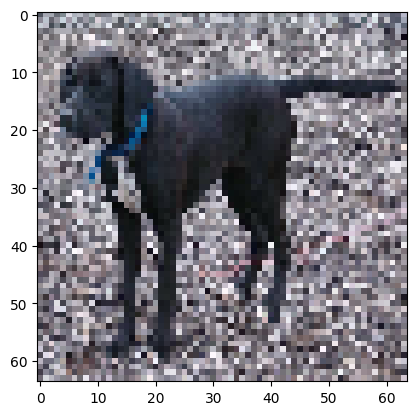

In [31]:
# Comprobar que ahora la primera imagen no es la misma que antes
plt.imshow(X_train[0])

In [32]:
# Entrenamos solo una época para ver lo lento que es, así que el modelo no será especialmente bueno
model.fit(X_train,
          y_train,
          validation_split=0.2,
          batch_size=32,
          #steps_per_epoch=10, # Cantidad de batches en los que divide el epoch
          epochs = 1)  

80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.5078 - loss: 66220.7656 - val_accuracy: 0.5031 - val_loss: 0.6943


In [33]:
# como hemos cambiado ahora los pesos, habría que entrenar mucho más
model.evaluate(X_test, y_test) 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.1794 - loss: 0.7298


[0.6946523785591125, 0.5]

Como era de esperar el rsultado no ha sido bueno, pero es que hemos entrenado muy poco el modelo. Si quieres mejor resultado, hay que poner más épocas.

Aquí termina la parte del transfer, en la siguiente sesión vamos a ver lo que sería un fine-tuning de las ResNet
***

## Fine-tuning: ResNet50V2

Cargamos el modelo pero ajustándolo a imagenes de 32x32 y observa que no cargamos pesos en la red, solo la topología. Y tampoco nos quedamos con las cabezas superiores.

Vamos a quitar la cabeza y los pesos (que en el caso anterior no hicimos esto último).

In [35]:
IM_SIZE=32

# weights=None --> Eliminamos los pesos
base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False, 
                        weights=None, 
                        classifier_activation="softmax")

In [36]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(base_model.input, x)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['acc']
              )


In [37]:
df_train

,filenames,category
0,github_train_3/dog.11816.jpg,dog
1,github_train_0/cat.2237.jpg,cat
2,github_train_0/cat.267.jpg,cat
3,github_train_3/dog.12150.jpg,dog
4,github_train_1/cat.2358.jpg,cat
...,...,...
3195,github_train_2/dog.11997.jpg,dog
3196,github_train_2/dog.11460.jpg,dog
3197,github_train_3/dog.11228.jpg,dog
3198,github_train_2/dog.11502.jpg,dog


Volvemos a hacer uso del aumentado del dataset mediante la manipulación de las imagenes originales

In [38]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory='./data/',        # Donde buscar todo esto
                                                    x_col='filenames',          # Nombres de archivos
                                                    y_col='category',           # Target
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_validate,
                                                              directory='./data/',
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(IM_SIZE, IM_SIZE))

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [40]:
# Para reducir los tiempos de entrenamiento solo haremos epocas de 100 steps, de 
# 32 datos (batch) (porque 3200/100=32) o sea entrenamos con 3000 imagenes por época
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=100, 
                    epochs=10) 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - acc: 0.5195 - loss: 0.8348 - val_acc: 0.5000 - val_loss: 0.7233
Epoch 2/10
 60/100 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - acc: 0.5020 - loss: 0.7859

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - acc: 0.5069 - loss: 0.7787 - val_acc: 0.5000 - val_loss: 0.7043
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - acc: 0.5581 - loss: 0.7678 - val_acc: 0.5038 - val_loss: 0.7023
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - acc: 0.5493 - loss: 0.7304 - val_acc: 0.4913 - val_loss: 0.7037
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - acc: 0.5608 - loss: 0.7354 - val_acc: 0.5213 - val_loss: 0.7055
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - acc: 0.5385 - loss: 0.7219 - val_acc: 0.5387 - val_loss: 0.7052
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - acc: 0.5482 - loss: 0.7202 - val_acc: 0.5475 - val_loss: 0.7260
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - acc: 0.5746 - loss: 0.7031 - val_acc: 0.5500 - val_loss: 0.7338
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - acc: 0.5439 - loss: 0.7036 - val_acc: 0.5275 - val_loss: 0.8558
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14

Y ya está. Evidentemente, debes optar cambiar los hiperparámetros y ajustarlo lo más posible a tu problema y a correr.

In [41]:
X_test.shape

(1000, 64, 64, 3)

In [46]:
X_test_resized = tf.image.resize(images=X_test, size=(32,32))
X_test_resized.shape

TensorShape([1000, 32, 32, 3])

In [47]:
model.evaluate(X_test_resized, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - acc: 0.6208 - loss: 0.6529


[0.7010475993156433, 0.5289999842643738]

Un resultado regular... Se podía ajustar los hiperparámetros o entrenar más épocas.

### Repositorios de modelos

Aquí te dejo unas cuantas direcciones a repositorios de modelos:

[Tensorflow Hub](https://www.tensorflow.org/hub?hl=es-419)

[Aplicaciones de Keras](https://keras.io/api/applications/)

[Pytorch Hub](https://pytorch.org/hub/)

[Huggin Face's Transformers](https://huggingface.co/docs/transformers/index)

In [48]:
# Eliminar todas las carpetas creadas en este notebook
# directory = './data'
# remove_non_zip_folders(directory)

Removing folder: ./data\github_test
Removing folder: ./data\github_train
Removing folder: ./data\github_train_0
Removing folder: ./data\github_train_1
Removing folder: ./data\github_train_2
Removing folder: ./data\github_train_3
